In [1]:
import glob
import pandas as pd
import numpy as np
import awkward as ak

import utils.tools as tools
import utils.plotting as plotting

from collections import OrderedDict, defaultdict
import uproot

import mplhep as cms
import matplotlib.pyplot as plt

cms.style.use("CMS")
plt.rcParams["figure.figsize"] = (7,7)

In [2]:
nComp = 3

l1Labels = ['Default', 'BaselineZS', 'ConservativeZS']
branchTypes = ['emu', 'emu', 'emu'] # unp or emu


rootDir = "/eos/cms/store/group/dpg_trigger/comm_trigger/L1Trigger/ddharmen/JECs2025/"
zmumu="zmumu/RAW_RECO/"
zerobias="zerobias/RAW/"

finalpath="0003/"

sigPaths  = ["default/Muon0/jetMET24I/250228_195726/", "baseline/Muon0/jetMET24I/250228_195617/", "conservative/Muon0/jetMET24I/250228_195652/"]
bkgPaths  = ["default/ZeroBias/jetMET24I/250301_183717/", "baseline/ZeroBias/jetMET24I/250301_183552/", "conservative/ZeroBias/jetMET24I/250301_183634/"]
fileName = "nano*.root"


# inputFormat = 'nano'     # nanoAOD
inputFormat = 'hdf5'     # pandas dataframes

sigName = "zmu"
bkgName = "zb"

writeDir = "./data_HT/"

# fileName = "/eos/home-d/ddharmen/JEC/CMSSW_14_1_4_patch1/src/JETMET/zerobias_perf_raw_test/default/nano*.root"
fileName = "nano_37*.root"
# fileName = "nano_99.root"

sigFiles = [glob.glob(rootDir + zmumu + path + finalpath + fileName) for path in sigPaths]
bkgFiles = [glob.glob(rootDir + zerobias + path + finalpath + fileName) for path in bkgPaths]

# len(sigFiles)
# len(bkgFiles)

In [3]:
if len(l1Labels) != nComp or len(branchTypes) != nComp or len(sigFiles) != nComp or len(bkgFiles) != nComp:
       raise TypeError("Number of inputs datasets is not consistent")


awkSigFiles = [writeDir + "/" + sigName + label + ".parq" for label in l1Labels]
awkBkgFiles = [writeDir + "/" + bkgName + label + ".parq" for label in l1Labels]

sig_hdf5s = [writeDir + "/" + sigName + label + ".hdf5" for label in l1Labels]
bkg_hdf5s = [writeDir + "/" + bkgName + label + ".hdf5" for label in l1Labels]

# L1 thresholds (GeV)
l1JetThresholds = [30, 120, 180]
l1METThresholds = [50, 90]
# arrays containing our signal and background data
# for the different sets of input files
sigs = []
bkgs = []

sig_dfs = []
bkg_dfs = []

In [4]:
# print("Signal files:", sigFiles)
# print("Background files:", bkgFiles)

In [5]:
if inputFormat == 'nano':
    
    for sigFile, awkSigFile, branchType in  zip(sigFiles, awkSigFiles, branchTypes):
        sigs.append(tools.getArrays(sigFile, tools.getBranches(['Jet'], branchType=='emu', False), len(sigFile), awkSigFile))
                       
    for bkgFile, awkBkgFile, branchType in zip(bkgFiles, awkBkgFiles, branchTypes):
        bkgs.append(tools.getArrays(bkgFile, tools.getBranches(['Jet'], branchType=='emu', False), len(bkgFile), awkBkgFile))


if inputFormat == 'parquet':

    for awkSigFile in awkSigFiles:
        sigs.append(ak.from_parquet(awkSigFile))

    for awkBkgFile in awkBkgFiles:
        bkgs.append(ak.from_parquet(awkBkgFile))

In [6]:
if inputFormat in ['nano', 'parquet']:

    for sig, sig_hdf5, l1Label in zip(sigs, sig_hdf5s, l1Labels):
        # get the puppiJETs
        puppiJET, puppiJETNoMu = tools.getPUPPIJET(sig)
        # puppiJET, puppiJETNoMu = tools.getPUPPIJET(sig)
        # get the l1JETs
        # l1JET_df = pd.DataFrame(ak.to_list(ak.flatten(tools.getSum(sig, 'JEThf')['EtSum_pt'])), columns=[l1Label])
        l1JET_df = pd.DataFrame(ak.to_list(tools.getL1EmulHT(sig)), columns=[l1Label])
        puppiJET_df = pd.DataFrame(ak.to_list(puppiJET['recoJet_ht']), columns=['PuppiJET'])
        # puppiJETNoMu_df = pd.DataFrame(ak.to_list(puppiJETNoMu['recoJet_ht']), columns=['PuppiJETNoMu'])
        # save to dataframe
        pd.concat([l1JET_df, puppiJET_df], axis=1).to_hdf(sig_hdf5, l1Label, mode='w')
        
    for bkg, bkg_hdf5, l1Label in zip(bkgs, bkg_hdf5s, l1Labels):
        
        l1JET_df = pd.DataFrame(ak.to_list(tools.getL1EmulHT(bkg)), columns=[l1Label])
        l1JET_df.to_hdf(bkg_hdf5, l1Label, mode='w')
        
    
for sig_hdf5, l1Label in zip(sig_hdf5s, l1Labels):
    sig_dfs.append(pd.read_hdf(sig_hdf5, l1Label))
    
for bkg_hdf5, l1Label in zip(bkg_hdf5s, l1Labels):
    bkg_dfs.append(pd.read_hdf(bkg_hdf5, l1Label))

In [7]:
print(type(sig_dfs))
for sig_df, l1Label in zip(sig_dfs, l1Labels):
    if (sig_df[l1Label] == 2047).any():
        print("yowza")

<class 'list'>
yowza
yowza
yowza


In [9]:
for i, df in enumerate(sig_dfs):
    for l1Label in l1Labels:
        if l1Label in df.columns:
            sig_dfs[i] = df[df[l1Label] != 2047]

In [16]:
# for sig_df, l1Label in zip(sig_dfs, l1Labels):
#     # Remove rows where the value in l1Label column is 2047
#     sig_df[l1Label] = sig_df[l1Label].replace(2047, np.nan)
#     print(sig_df)

In [17]:
print(type(sig_dfs))
for sig_df, l1Label in zip(sig_dfs, l1Labels):
    if (sig_df[l1Label] == 2047).any():
        print("yowza")

<class 'list'>


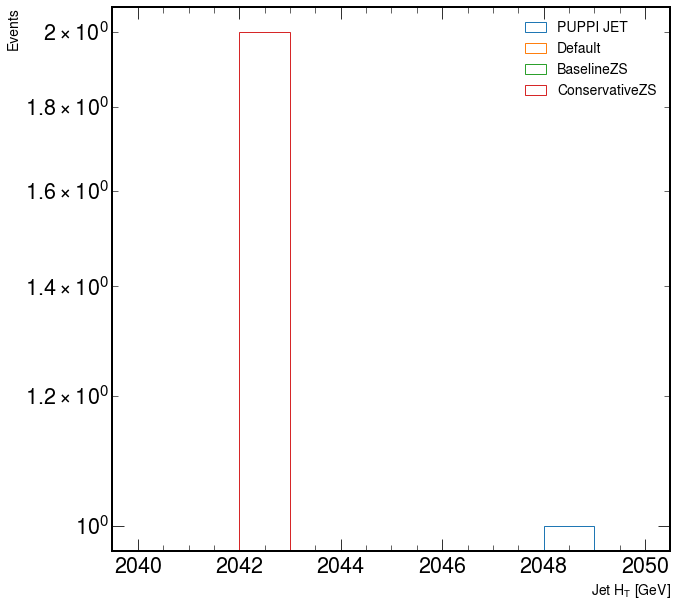

In [27]:
# sig_dfs[0]['PuppiJET'] = sig_dfs[0]['PuppiMET']
# sig_dfs['PuppiJET'] = sig_dfs['PuppiMET']
plt.hist(sig_dfs[0]['PuppiMET'], bins = 10, range = [2040,2050], histtype = 'step', log = True, label = "PUPPI JET")
# plt.hist(sig_dfs[0]['PuppiJETNoMu'], bins = 100, range = [0,2000], histtype = 'step',  label = "PUPPI JET NoMu")

for sig_df, l1Label in zip(sig_dfs, l1Labels):
    plt.hist(sig_df[l1Label], bins = 10, range = [2040,2050], histtype = 'step', label = l1Label)


plt.legend(fontsize=14)
plt.xlabel(r'Jet H$_T$ [GeV]', fontsize=14)
plt.ylabel('Events', fontsize=14)
plt.yscale('log')
plt.savefig("plots_jetHT/JET_ht.pdf", format="pdf")
plt.show()


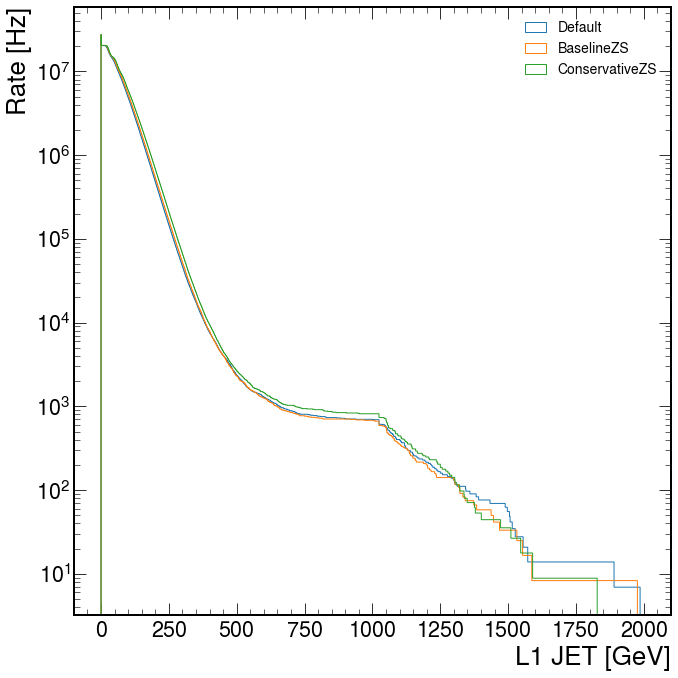

In [25]:
# make fixed rate JET efficiencies

# rate plots must be in bins of GeV
ptRange = [0,2000]
bins = ptRange[1]

l1JETRates = []
l1JETThresholds = [120, 240, 360]

l1JETThresholdsArr = [l1JETThresholds]

# get rate hist for "default" objects
rateScale = 40000000*(2452/3564)/len(bkg_dfs[0])
rateHist = plt.hist(bkg_dfs[0], bins=bins, range=ptRange, histtype = 'step', label=l1Labels[0], cumulative=-1, log=True, weights=np.full(len(bkg_dfs[0]), rateScale))

for l1JETThreshold in l1JETThresholds:
    # get rates for the default thresholds
    l1JETRate = rateHist[0][l1JETThreshold]
    l1JETRates.append(l1JETRate)

for i in range(1, nComp):
    # get thresholds for the fixed rates
    rateScale = 40000000*(2452/3564)/len(bkg_dfs[i])
    rateHist = plt.hist(bkg_dfs[i], bins=bins, range=ptRange, histtype = 'step', label=l1Labels[i], cumulative=-1, log=True, weights=np.full(len(bkg_dfs[i]), rateScale))
    thresholds = []
    for l1JETThreshold in l1JETThresholds:
        # get threshold for this rate
        thresholds.append(plotting.getThreshForRate(rateHist[0], bins, l1JETRates[l1JETThresholds.index(l1JETThreshold)]))
    l1JETThresholdsArr.append(thresholds)

plt.legend(fontsize=14)
plt.xlabel('L1 JET [GeV]')
plt.ylabel('Rate [Hz]')
plt.yscale('log')
plt.tight_layout()
plt.savefig("plots_jetHT/JET_rates.pdf", format="pdf")
# plt.clf()
plt.show()

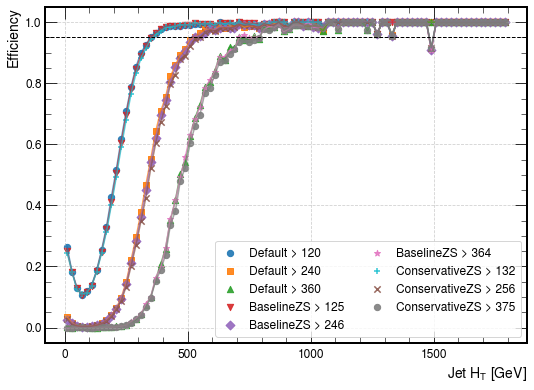

In [26]:
import matplotlib.pyplot as plt
from itertools import cycle
plt.style.use(cms.style.ROOT)

# Define markers and colors
markers = cycle(['o', 's', '^', 'v', 'D', '*', '+', 'x'])
colors = cycle(['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', 
                '#e377c2', '#17becf', '#8c564b', '#7f7f7f', '#bcbd22'])

plt.figure(figsize=(8, 6))  # Increase figure size

for sig_df, l1Label, l1JETThresholds in zip(sig_dfs, l1Labels, l1JETThresholdsArr):
    for l1JETThreshold in l1JETThresholds:
        eff_data, xvals, err = plotting.efficiency(sig_df[l1Label], sig_df['PuppiMET'], l1JETThreshold, 20, 1800)
        
        color = next(colors)
        marker = next(markers)
        
        # Scatter plot for exact points
        plt.scatter(xvals, eff_data, 
                    label=f"{l1Label} > {l1JETThreshold}", 
                    marker=marker, 
                    color=color, 
                    s=40,  # Increase marker size
                    alpha=0.9)  # Transparency for better readability

        # Line plot to connect points
        plt.plot(xvals, eff_data, 
                 linestyle='-',  # Solid line
                 color=color, 
                 alpha=0.7,  # Slight transparency
                 linewidth=1.5)  # Moderate line width

# Reference line at 95% efficiency
plt.axhline(0.95, linestyle='--', color='black', linewidth=1)

# Formatting
plt.legend(fontsize=12, loc='lower right', ncol=2, frameon=True)  # Adjust legend
plt.xlabel(r'Jet H$_T$ [GeV]', fontsize=14)
plt.ylabel('Efficiency', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)  # Add a light grid
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()

# Save the figure
plt.savefig("plots_jetHT/Jet_eff.pdf", format="pdf", dpi=300)  # Higher DPI for clarity
plt.show()  # Show instead of clearing immediately
